This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_bistable2
from stochastic_tests import Test
import stochastic_repro as sr

t_fin = 10.0
num_steps = 1000
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

a1_mean = 0.9
a2_mean = 1.1

test1 = Test(model=model_bistable2({'a': ('norm', (a1_mean, 0.2))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_bistable2({'a': ('norm', (a2_mean, 0.2))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

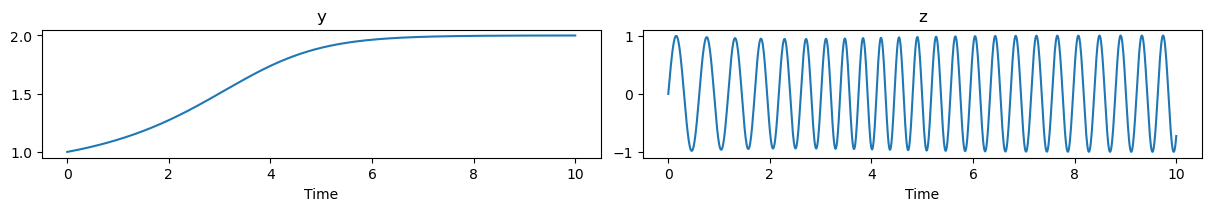

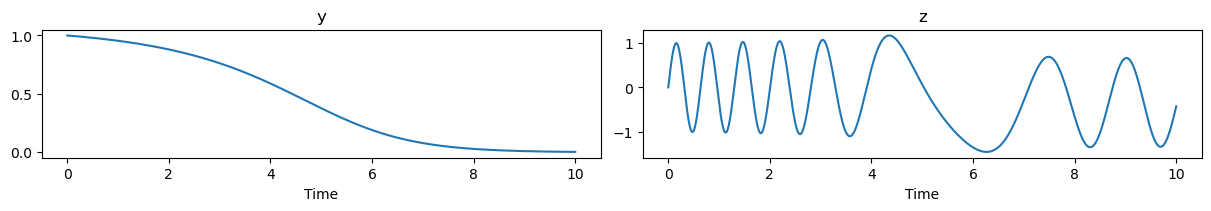

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

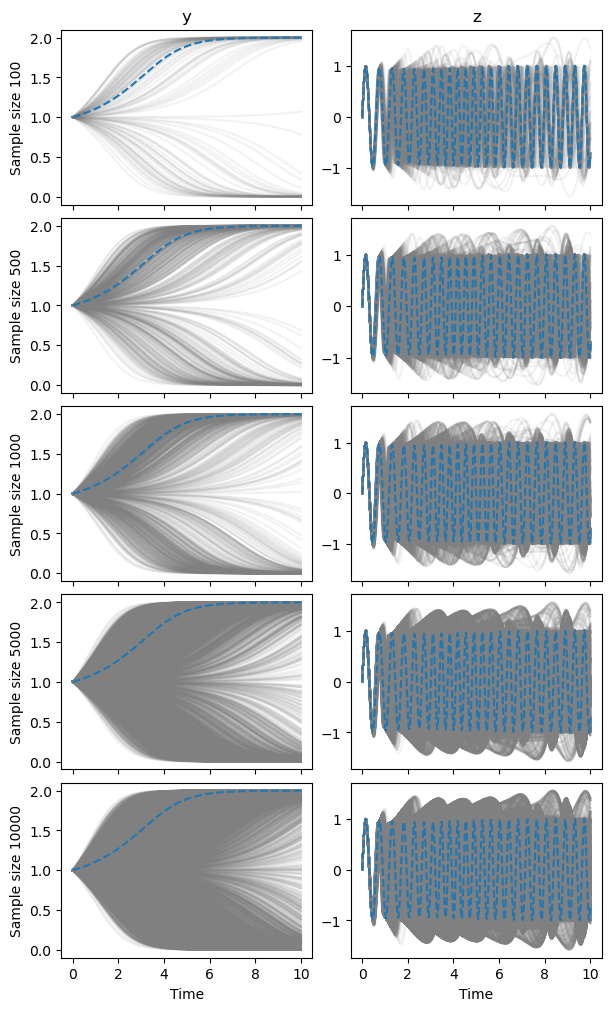

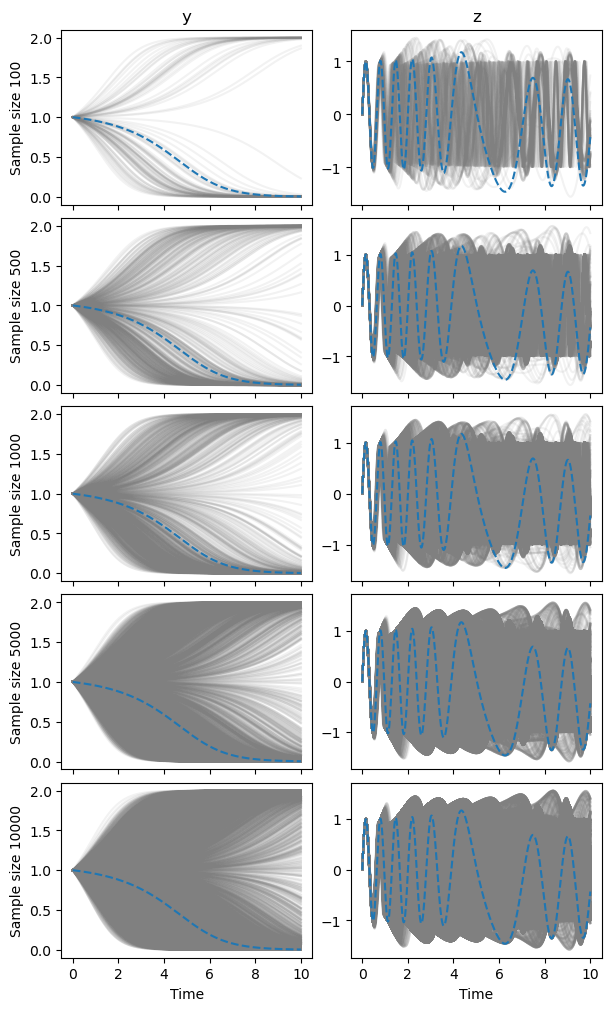

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

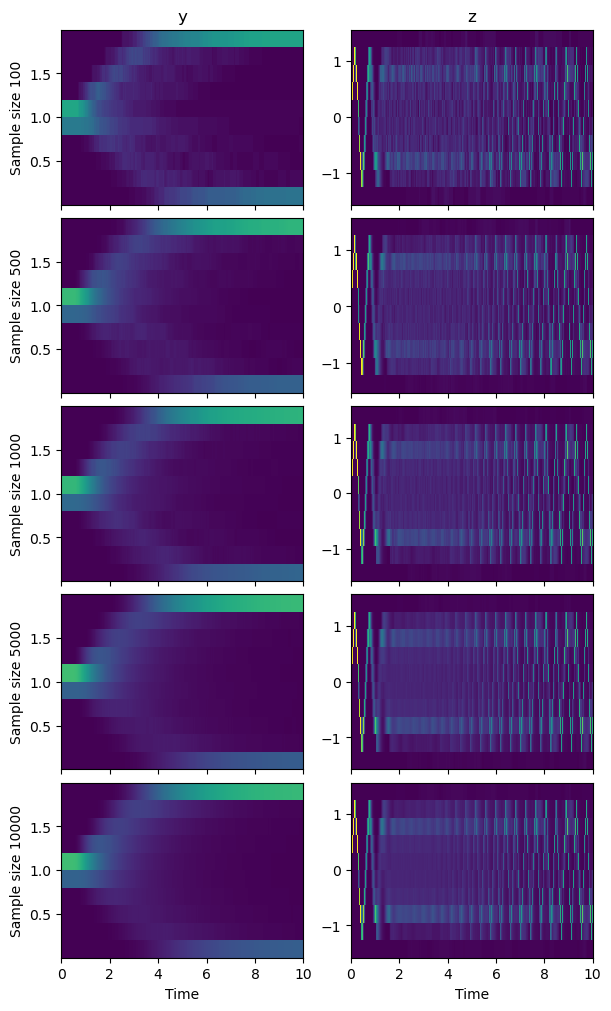

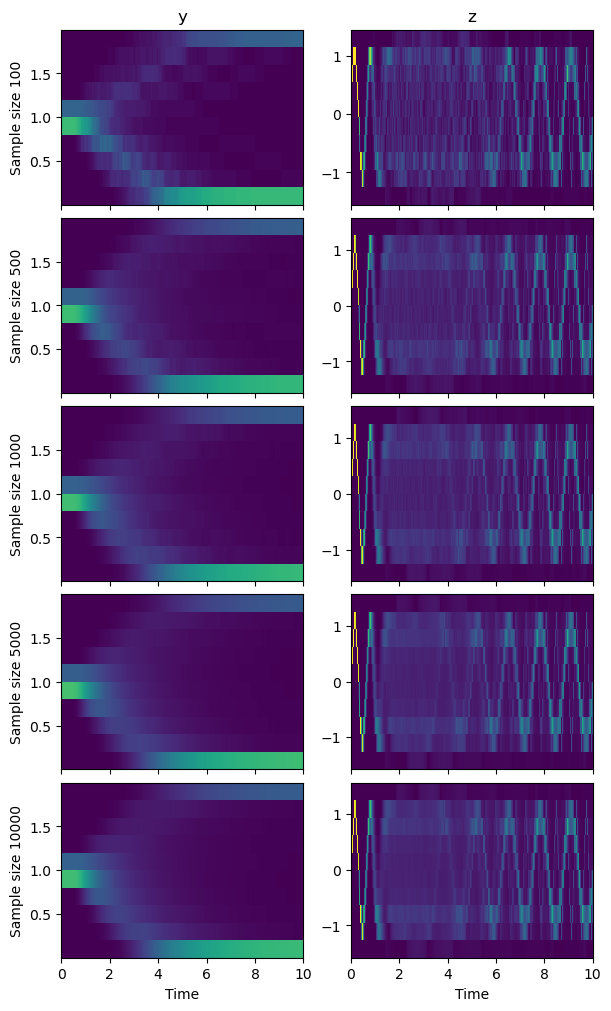

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


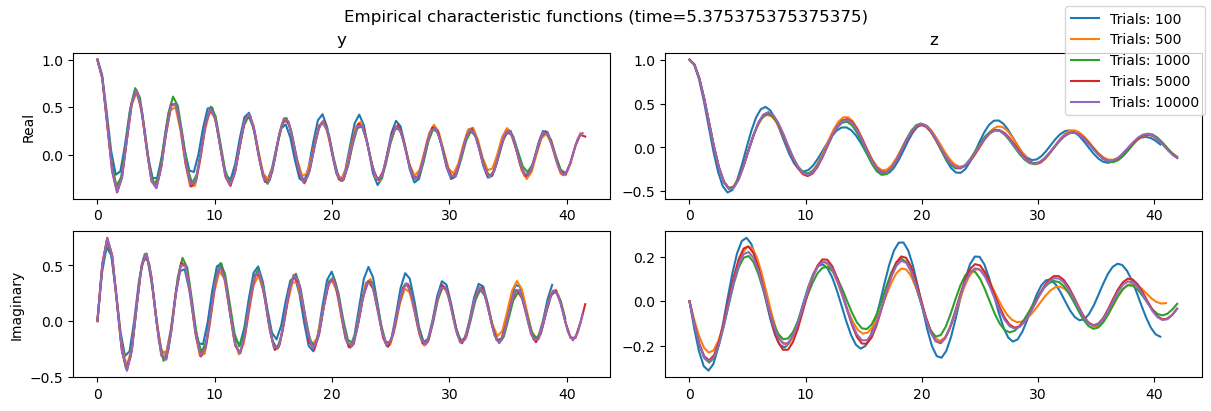

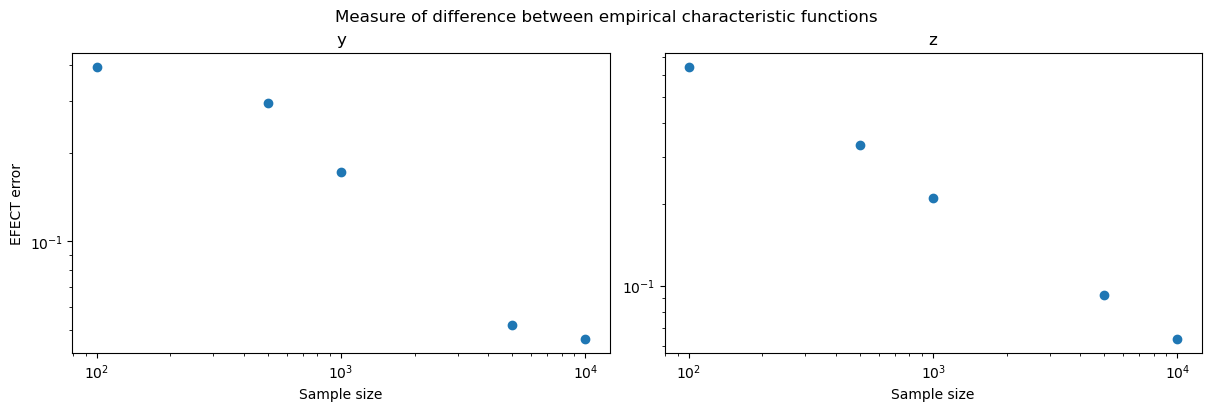

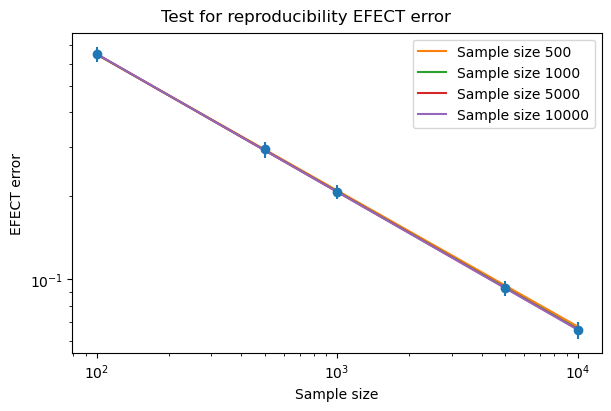

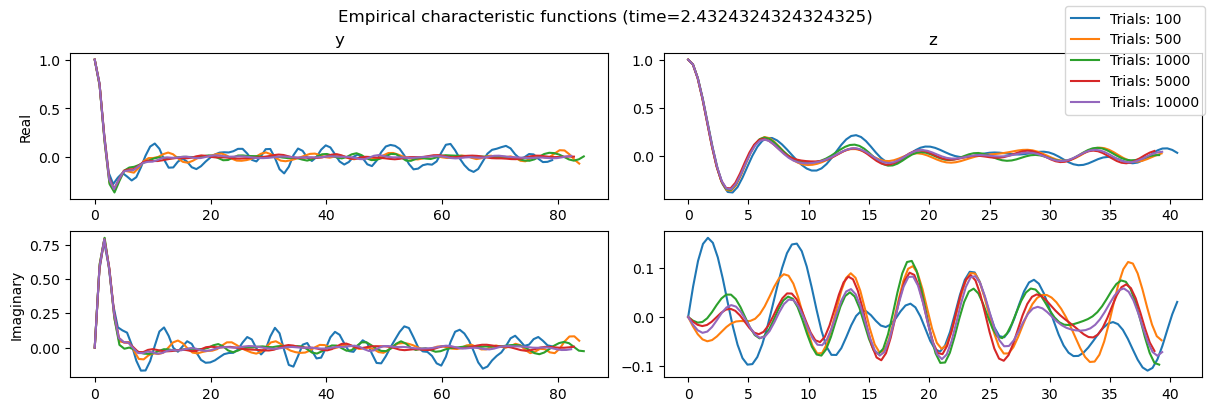

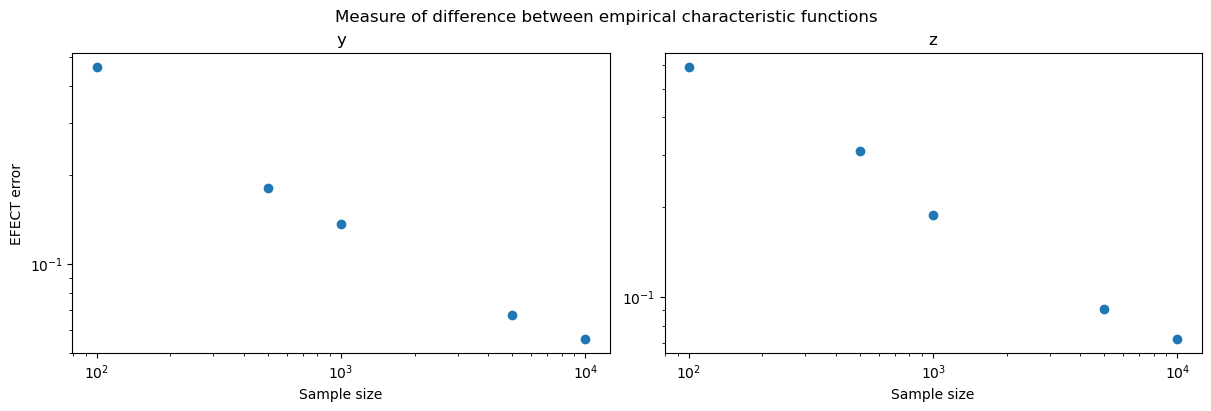

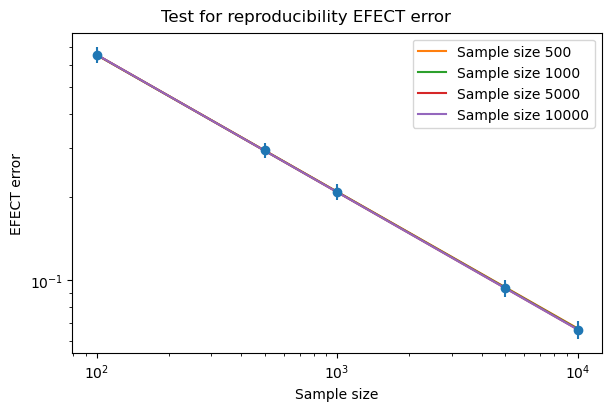

In [6]:
# Runtime: ~159 minutes (M1 max)
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

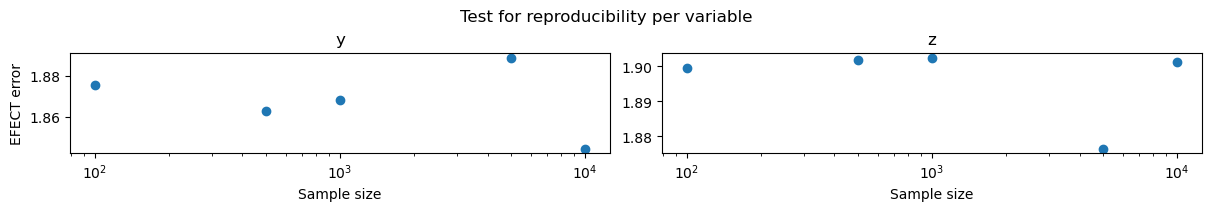

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in model parameters. 

Output()

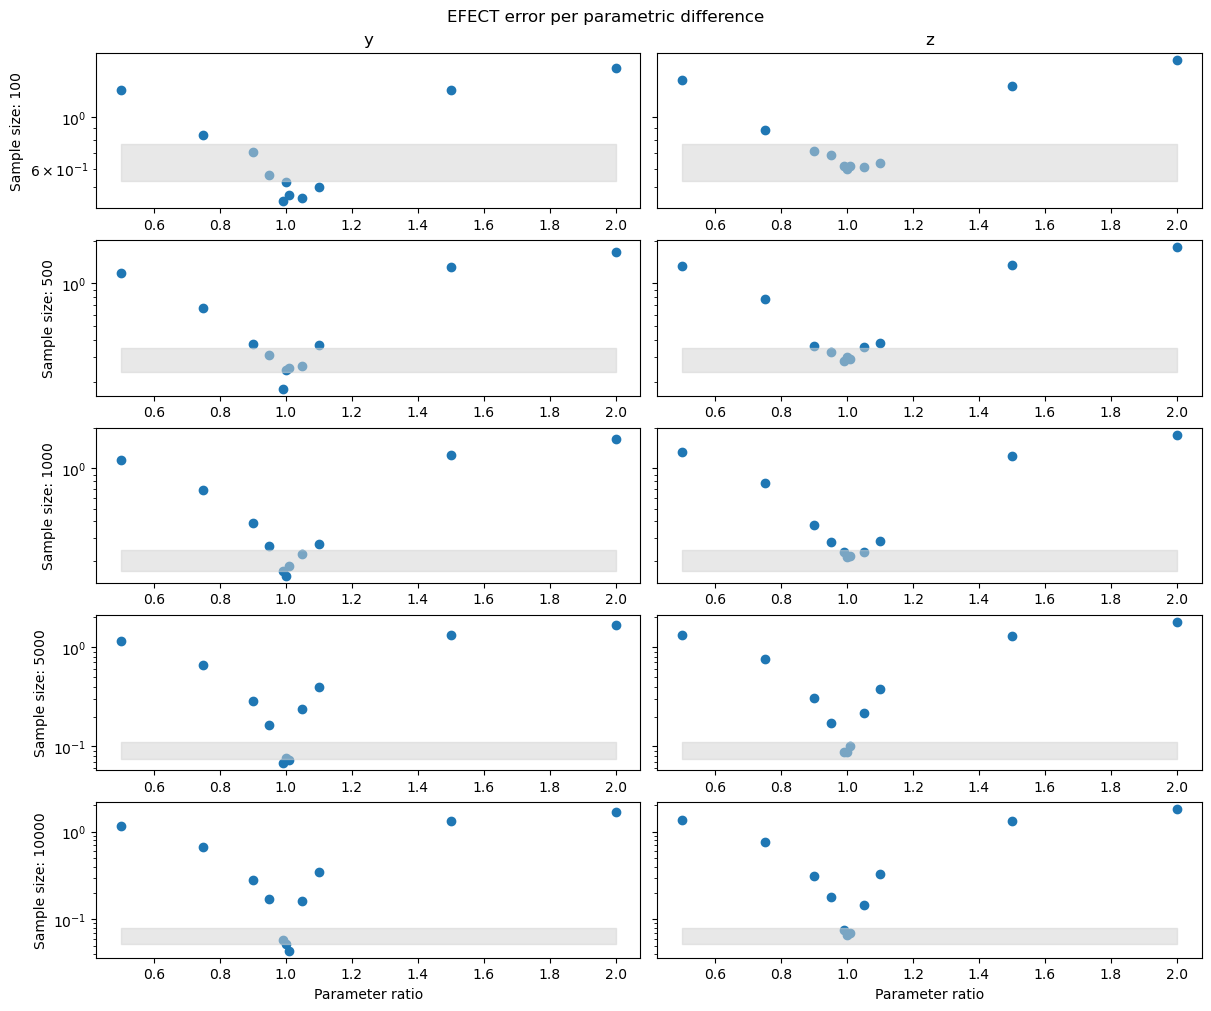

In [8]:
a_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
a_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for af in a_fact:
    label.value = f'Factor: {af}...'

    atest_mean = a1_mean * af
    test = Test(model=model_bistable2({'a': ('norm', (atest_mean, 0.2))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    a_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(a_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in a_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(a_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    sz = len(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in a_comp]
    q2 = (sz + 1) / sz * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sz + 1) / sz * ((sz - 1) / l2 + 1)) / (sz + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(a_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.647695,0.039583
500,0.29403,0.019041
1000,0.206722,0.012658
5000,0.092991,0.006016
10000,0.065732,0.004582


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           1.455162     20.399415         0.004975                    100   
            0.75           0.887006     6.045822          0.029851                    100   
            0.90           0.713426     1.660597          0.368159                    100   
            0.95           0.690308     1.076557          0.870647                    100   
            0.99           0.615487    -0.813676          1.000000                    100   
            1.00           0.596827    -1.285109          1.000000                    100   
            1.01           0.618438    -0.739135          1.000000                    100   
            1.05           0.613258    -0.869992          1.000000                    100   
            1.10           0.633555    -0.357226          1.000000                    100   
            1.50           1.369292     18.230047         0.004975                    100   
            2.00           1.770931     28.376837         0.004975                    100   
500         0.50           1.332523     54.538662         0.003322                    500   
            0.75           0.770334     25.014115         0.003322                    500   
            0.90           0.372928     4.143515          0.059801                    500   
            0.95           0.324063     1.577277          0.405316                    500   
            0.99           0.280911    -0.688932          1.000000                    500   
            1.00           0.302669     0.453722          1.000000                    500   
            1.01           0.289137    -0.256953          1.000000                    500   
            1.05           0.354285     3.164452          0.102990                    500   
            1.10           0.379881     4.508682          0.049834                    500   
            1.50           1.341560     55.013237         0.003322                    500   
            2.00           1.795216     78.837985         0.003322                    500   
1000        0.50           1.331640     88.867841         0.001996                   1000   
            0.75           0.781997     45.446368         0.001996                   1000   
            0.90           0.387355     14.269911         0.005988                   1000   
            0.95           0.280601     5.836448          0.029940                   1000   
            0.99           0.236738     2.371275          0.179641                   1000   
            1.00           0.215746     0.712925          1.000000                   1000   
            1.01           0.219176     0.983923          1.000000                   1000   
            1.05           0.234315     2.179842          0.211577                   1000   
            1.10           0.284840     6.171332          0.027944                   1000   
            1.50           1.261895     83.358055         0.001996                   1000   
            2.00           1.790530     125.119863        0.001996                   1000   
5000        0.50           1.330471     205.702757        0.004975                   5000   
            0.75           0.751362     109.439061        0.004975                   5000   
            0.90           0.309617     36.009027         0.004975                   5000   
            0.95           0.171971     13.128515         0.009950                   5000   
            0.99           0.087148    -0.971276          1.000000                   5000   
            1.00           0.087452    -0.920803          1.000000                   5000   
            1.01           0.101698     1.447381          0.482587                   5000   
            1.05           0.236090     23.786885         0.004975                   5000   
            1.10           0.392619     49.806333         0.004975             